In [1]:
import os
import sys
import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
%matplotlib inline
# %matplotlib notebook

from glob import glob
timer = cy.timing.Timer()
time = timer.time

sys.path.append('../../')
from greco_grb.scripts import SETTING
paths = SETTING.PATH()
print(paths)
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from greco_grb.scripts.utils import *


#### Working at GT ####

LOCATION: 	 GT
USER: 	 cchen641
ICDATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/analyses/online_GRECO/candidate-002-p10
DATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data
ANA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output



In [2]:
print("\n===== Setting up csky =====\n")
data_dir = ICDATA_DIR
data_filenames = sorted(glob(data_dir + '/IC86_20*.data.npy'))
sig_filenames = sorted(glob(data_dir + '/IC86_2012.nu*_merged.npy'))
grl_filenames = sorted(glob(data_dir + '/GRL/IC86_20*.data.npy'))

################ energy lower bound #############
min_log_e = np.log10(10)
#################################################
bins_sindec = np.linspace(-1, 1, 25+1)  
# bins_logenergy = np.linspace(min_log_e, 5, 30+1)
bins_logenergy = np.linspace(min_log_e, 4, 25+1)

data = [np.load(data_filename) for data_filename in data_filenames]
data = np.hstack(data)
sig = [np.load(sig_filename) for sig_filename in sig_filenames]
sig = np.hstack(sig)
grl = [np.load(grl_filename) for grl_filename in grl_filenames]
grl = np.hstack(grl)
if min_log_e is not None:
    data_mask = data['logE'] > min_log_e
    data = data[data_mask]
    sig_mask = sig['logE'] > min_log_e
    sig = sig[sig_mask]
    
dataset_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, sig, np.sum(grl['livetime']),
                                                     sindec_bins=bins_sindec,
                                                     logenergy_bins=bins_logenergy,
                                                     grl=grl, key='greco_v2.10', cascades=True)

ANA_DIR = cy.utils.ensure_dir(ANA_DIR)
# on OSG
# ana_dir = "./"
ana = cy.get_analysis(cy.selections.repo
                      , dataset_spec
                      , dir=ANA_DIR
                      , load_sig=True)  # to save memory: use False




===== Setting up csky =====

Setting up Analysis for:
greco_v2.10
Setting up greco_v2.10...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [112]:
ana[0].grl.events.sum() / (0.001 * 86400 * ana[0].grl.livetime.sum())

4.607932049722196

In [113]:
grl = ana[0].grl[ana[0].grl.livetime > 0.3]
rates = grl.events / (0.001 * 86400. * grl.livetime)
np.percentile(rates, 50), np.percentile(rates, 84), np.percentile(rates, 16)

(4.6150075768869705, 5.034446670943363, 4.199894397047974)

In [115]:
def get_event_rate_plot(grl, bin_width=7., **kwargs):
    """
    Plot TS distribution(s) and produce one plot
    
    Parameters
    ----------
    grl : csky.utils.Arrays
        e.g.: ana[0].grl
    
    bin_width : float
        interval length in days
        
    Returns
    -------
    N/A
    
    See also
    -------
    N/A
    """
    if 'ax' in kwargs:
        ax = kwargs['ax']
    else:
        fig, ax = plt.subplots()
        
    rates = grl.events / (0.001 * 86400. * grl.livetime)
    mjds = (grl.start + grl.stop) / 2
    h = hl.hist((mjds, rates), 
            bins=(np.r_[grl.start[0]:grl.stop[-1]+bin_width:bin_width], 100), 
            range=((56000,59040), (1,8)))
    h = h
    h = h.normalize(1).to_finite()
    h = h.contain_project(1, .5)
    hl.plot1d(ax, h, errorbands=True, drawstyle='default', color='#004466', label="IC86")
    ax.hlines(y=np.nanmean(h.values),  xmin=grl.start[0], xmax=grl.stop[-1], color='#d06050', label="Mean rate")
    
    ax.set_xlim(grl.start[0], grl.stop[-1])
    ax.set_ylim(3.2, 6.0)
    ax.set_ylabel('Rate (mHz)', fontsize = 20)
    ax.set_xlabel('Time (MJD)', fontsize = 20)
    ax.legend(loc=2, fontsize=14, frameon=True)
    return rates, h

In [116]:
ana[0].grl[ana[0].grl.livetime > 0.3]

Arrays(7948 items | columns: events, livetime, run, start, stop)

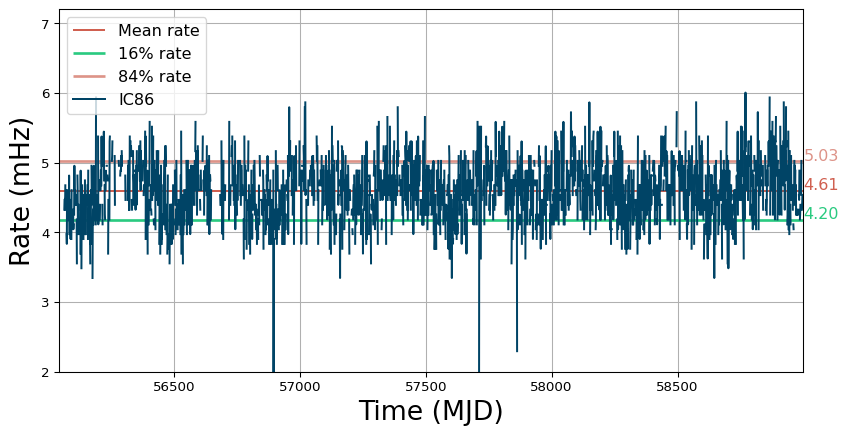

In [117]:
fig, ax = plt.subplots(figsize=(10,5), dpi=96)
rates, h = get_event_rate_plot(ana[0].grl[ana[0].grl.livetime > 0.3][0:7984:4], bin_width=1., ax=ax)
ax.set_ylim(2, 7.2)
ax.hlines(y=np.percentile(rates, 16),  xmin=56000, xmax=60000, color='#2aca80', label="16% rate", linewidth=2)
ax.hlines(y=np.percentile(rates, 84),  xmin=56000, xmax=60000, color='#dd9388', label="84% rate", linewidth=2)
ax.legend(loc=2, fontsize=12, frameon=True)
ax.text(x=59000,y=4.61, s="4.61",color='#d06050', fontsize = 12)
ax.text(x=59000,y=4.20, s="4.20",color='#2aca80', fontsize = 12)
ax.text(x=59000,y=5.03, s="5.03",color='#dd9388', fontsize = 12)
ax.grid()

In [131]:
x = (h.bins[0][0:-1] + h.bins[0][1:])/2
x = x[~np.isnan(h.values)]
y = h.values[~np.isnan(h.values)]


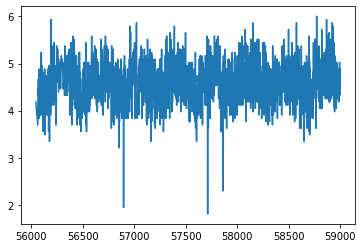

In [133]:
plt.plot(x, y)

In [142]:
short_grl = ana[0].grl[ana[0].grl.livetime <= 0.3]

In [143]:
short_rates = short_grl.events / (0.001 * 86400. * short_grl.livetime)

In [148]:
np.quantile(short_rates, 0.16)

3.529048703933944